# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Logistic Regression** </center>
---

**Date**: November, 2025

**Student Name**: Axel Leonardo Fernandez Albarran

**Professor**: Pablo Camarillo Ramirez

## 1. Machine Learning algorithm to use

En este proyecto voy a usar **Logistic Regression** para resolver un problema de **clasificación binaria**:

- **Objetivo:** predecir si un pasajero del Titanic **sobrevive (1)** o **no sobrevive (0)**.
- **Variable objetivo:** `Survived`.

### ¿Por qué Logistic Regression?

Decidí usar **Logistic Regression** porque es el algoritmo de clasificación con el que estoy más familiarizado por otras clases como mineria de datos y me permite entender bien el pipeline Spark sin perderme tan facil como lo podria hacer con un en un modelo demasiado complejo.

Ademas de que la la columna objetivo es binaria (0/1)

In [22]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ML Final Project: Titanic Logistic Regression") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

spark.conf.set("spark.sql.shuffle.partitions", "5")


## 2. Dataset Description

El dataset es **Titanic – Machine Learning from Disaster** de Kaggle.

- **Tipo de problema:** Clasificación binaria (`Survived`)
- **Dataset**: https://www.kaggle.com/competitions/titanic/data?select=train.csv

Los datos que podemos encontrar dentro del dataset son:

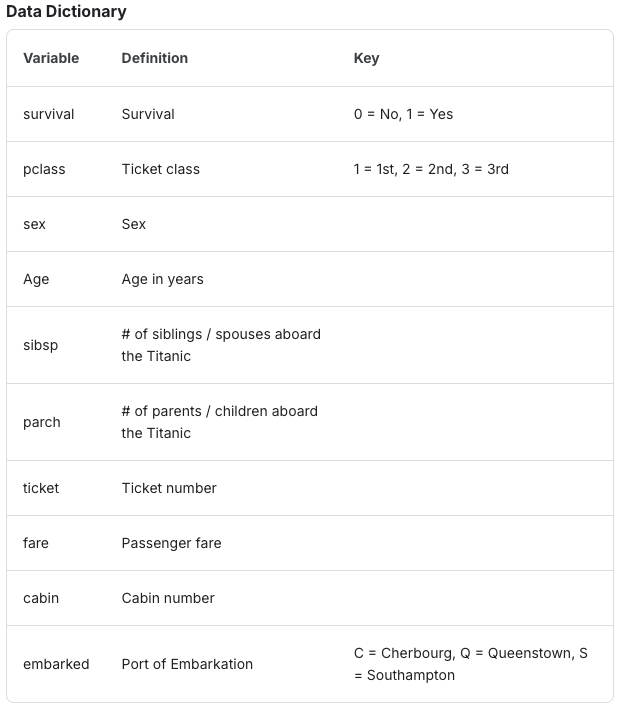


El dataset tiene las siguientes características:

- **Número de filas:** 891  
- **Atributos:** 12  

In [23]:

from pyspark.sql.functions import col, lit, avg, when

# Ruta donde tengo el archivo CSV de titanic
path = "/opt/spark/work-dir/data/titanic/titanicTrain.csv"

# Cargo el dataset
titanic_df = (spark.read
              .option("header", "true")
              .option("inferSchema", "true")
              .csv(path))

print("Número de filas:", titanic_df.count())
print("Número de columnas:", len(titanic_df.columns))
titanic_df.printSchema()

titanic_df.show(5, truncate=False)

Número de filas: 891
Número de columnas: 12
root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+---------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|Name                                               |Sex   |Age |SibSp|Parch|Ticket          |Fare   |Cabin|Embarked|
+-----------+--------+------+---------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|1          |0       |3     |Braund, Mr. Owen Harris   


Para analizar si el problema de clasificación está balanceado o no, calculé la distribución de la variable `Survived`

- **Clase 0 (no sobrevivió):** 549 registros ≈ 61.62 %  
- **Clase 1 (sobrevivió):** 342 registros ≈ 38.38 %


In [ ]:
label_col = "Survived"

total_count = titanic_df.count()
class_distribution = (titanic_df
    .groupBy(label_col)
    .count()
    .withColumn("percentage", col("count") * 100.0 / lit(total_count))
)

print("Distribución de Survived:")
class_distribution.show()


Distribución de Survived:
+--------+-----+-----------------+
|Survived|count|       percentage|
+--------+-----+-----------------+
|       0|  549|61.61616161616162|
|       1|  342|38.38383838383838|
+--------+-----+-----------------+



## 3. ML Training process

1. **Selección de variables** para el modelo.
2. **Preprocesamiento:**
3. Construcción del `VectorAssembler`.
4. División del dataset **train** y **test**.
5. Configuración de **Logistic Regression**.
6. Entrenamiento del modelo.
7. Guardado del modelo entrenado.


In [ ]:
# Seleccionamos columnas relevantes
cols_to_use = [
    "Survived",  # label
    "Pclass",
    "Sex",
    "Age",
    "SibSp",
    "Parch",
    "Fare"
]

df_ml = titanic_df.select(cols_to_use)

df_ml = df_ml.withColumnRenamed("Survived", "label") \
             .withColumn("label", col("label").cast("double"))

# Agarramos la media de Age y Fare para llenar los valores nulos
age_mean = df_ml.select(avg("Age")).first()[0]
fare_mean = df_ml.select(avg("Fare")).first()[0]
df_ml = df_ml.na.fill({"Age": age_mean, "Fare": fare_mean})

# Convertir Sex: male=1, female=0
df_ml = df_ml.withColumn("SexNum",when(col("Sex") == "male", 1.0).otherwise(0.0))
df_ml = df_ml.select("label", "Pclass", "SexNum", "Age", "SibSp", "Parch", "Fare")

df_ml.show(10, truncate=False)


+-----+------+------+-----------------+-----+-----+-------+
|label|Pclass|SexNum|Age              |SibSp|Parch|Fare   |
+-----+------+------+-----------------+-----+-----+-------+
|0.0  |3     |1.0   |22.0             |1    |0    |7.25   |
|1.0  |1     |0.0   |38.0             |1    |0    |71.2833|
|1.0  |3     |0.0   |26.0             |0    |0    |7.925  |
|1.0  |1     |0.0   |35.0             |1    |0    |53.1   |
|0.0  |3     |1.0   |35.0             |0    |0    |8.05   |
|0.0  |3     |1.0   |29.69911764705882|0    |0    |8.4583 |
|0.0  |1     |1.0   |54.0             |0    |0    |51.8625|
|0.0  |3     |1.0   |2.0              |3    |1    |21.075 |
|1.0  |3     |0.0   |27.0             |0    |2    |11.1333|
|1.0  |2     |0.0   |14.0             |1    |0    |30.0708|
+-----+------+------+-----------------+-----+-----+-------+
only showing top 10 rows


In [26]:
from pyspark.ml.feature import VectorAssembler

# Creamos el vector
assembler = VectorAssembler(
    inputCols=["Pclass", "SexNum", "Age", "SibSp", "Parch", "Fare"],
    outputCol="features"
)

data_with_features = assembler.transform(df_ml).select("label", "features")

print("Schema con features:")
data_with_features.printSchema()

# Dividimos en train y test
train_df, test_df = data_with_features.randomSplit([0.8, 0.2], seed=57)

print("Tamaño train:", train_df.count())
print("Tamaño test:", test_df.count())
train_df.show(5, truncate=False)


Schema con features:
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)

Tamaño train: 737
Tamaño test: 154
+-----+------------------------------+
|label|features                      |
+-----+------------------------------+
|0.0  |[1.0,0.0,2.0,1.0,2.0,151.55]  |
|0.0  |[1.0,0.0,25.0,1.0,2.0,151.55] |
|0.0  |[1.0,0.0,50.0,0.0,0.0,28.7125]|
|0.0  |[1.0,1.0,18.0,1.0,0.0,108.9]  |
|0.0  |[1.0,1.0,19.0,1.0,0.0,53.1]   |
+-----+------------------------------+
only showing top 5 rows


In [27]:
from pyspark.ml.classification import LogisticRegression

# Logistic Regression
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=20,    
    regParam=0.1, 
)



In [ ]:
# Entrenamos el modelo
lr_model = lr.fit(train_df)

# Coeficientes
print("Coefficients:", lr_model.coefficients)

Coefficients: [-0.48435082291877113,-1.6572724040172604,-0.013652088117705484,-0.11904967946180497,-0.028122653212253892,0.003255156685264761]


## 4. ML Evaluation

In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Predicciones en el test set
predictions = lr_model.transform(test_df)

predictions.select("features", "label", "prediction", "probability").show(10, truncate=False)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction"
)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy : {accuracy}")
print(f"Precision: {precision}")
print(f"Recall   : {recall}")
print(f"F1 Score : {f1}")


+----------------------------------------+-----+----------+----------------------------------------+
|features                                |label|prediction|probability                             |
+----------------------------------------+-----+----------+----------------------------------------+
|[1.0,1.0,29.69911764705882,0.0,0.0,35.0]|0.0  |0.0       |[0.5902540950158804,0.40974590498411956]|
|[1.0,1.0,29.69911764705882,0.0,0.0,39.6]|0.0  |0.0       |[0.5866278048297338,0.41337219517026624]|
|[1.0,1.0,31.0,0.0,0.0,50.4958]          |0.0  |0.0       |[0.5823272621255665,0.4176727378744335] |
|[1.0,1.0,37.0,0.0,1.0,29.7]             |0.0  |0.0       |[0.6248212812178296,0.37517871878217035]|
|[1.0,1.0,42.0,1.0,0.0,52.0]             |0.0  |0.0       |[0.6448919412221839,0.35510805877781615]|
|[1.0,1.0,58.0,0.0,0.0,29.7]             |0.0  |0.0       |[0.6832254044113087,0.31677459558869125]|
|[1.0,1.0,62.0,0.0,0.0,26.55]            |0.0  |0.0       |[0.6970937291334366,0.3029062708

## 5. Persistimos el modelo

In [30]:
# Ruta donde se guardará el modelo
model_path = "/opt/spark/work-dir/data/models/titanic_model"

# Guardar el modelo
lr_model.write().overwrite().save(model_path)

print(f"Modelo guardado en: {model_path}")

Modelo guardado en: /opt/spark/work-dir/data/models/titanic_model


## 6. Extraemos el modelo y volvemos a usarlo

In [31]:
from pyspark.ml.classification import LogisticRegressionModel

# Cargar el modelo
loaded_lr_model = LogisticRegressionModel.load(model_path)

# Usar el modelo cargado para predecir
loaded_predictions = loaded_lr_model.transform(test_df)

loaded_accuracy = evaluator.evaluate(loaded_predictions, {evaluator.metricName: "accuracy"})
loaded_f1 = evaluator.evaluate(loaded_predictions, {evaluator.metricName: "f1"})

print(f"Accuracy (loaded): {loaded_accuracy}")
print(f"F1 Score (loaded): {loaded_f1}")


Accuracy (loaded): 0.7987012987012987
F1 Score (loaded): 0.8000210139978587


In [32]:
sc.stop()